In [4]:
import numpy as np
import pandas as pd
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/ml-100k/u.data', sep='\t', names=header)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


In [5]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df,test_size=0.25)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Create training and test matrix
R = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]  

T = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]

/home/guilherme/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [7]:
# Predict the unknown ratings through the dot product of the latent features for users and items 
def prediction(P,Q):
    return np.dot(P.T,Q)

In [8]:
lmbda = 0.1 # Regularisation weight
k = 20  # Dimensionality of the latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 100  # Number of epochs
gamma=0.01  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [9]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

In [10]:
train_errors = []
test_errors = []

#Only consider non-zero matrix 
users,items = R.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
        #print(P)
    train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

/home/guilherme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/guilherme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':
/home/guilherme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':
/home/guilherme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: 

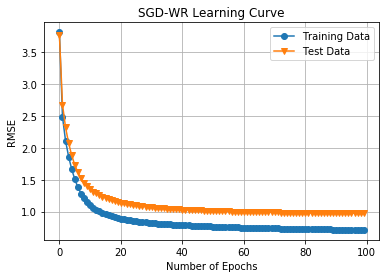

In [15]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [11]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

In [12]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,Actual Rating,Predicted Rating
6,4.0,3.567499
99,4.0,3.452510
110,3.0,2.957132
116,3.0,2.601002
125,4.0,3.518206
